## Olist Sales Analysis

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker
sns.set(palette = "dark")

In [2]:
#importing dataset
cust = pd.read_csv('olist_customers_dataset.csv')
geo = pd.read_csv('olist_geolocation_dataset.csv')
order_item = pd.read_csv('olist_order_items_dataset.csv')
order_pay = pd.read_csv('olist_order_payments_dataset.csv')
order_rev = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
product = pd.read_csv('olist_products_dataset.csv')
seller = pd.read_csv('olist_sellers_dataset.csv')
pro_cat = pd.read_csv('product_category_name_translation.csv')

#### DATA WRANGLING

In [3]:
#total orders
df_c = order_pay.merge(orders, on = 'order_id', how = 'left', validate = 'many_to_one')

#defining a function to clean the merged dataset
def clean_data(data):
    data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], format='%d/%m/%Y %H:%M')
    #slicing for dates considered for the business use case
    start_date = '2016-12-31 23:59:00'
    end_date = '2018-08-31 23:59:00'
    data = data[(data.order_purchase_timestamp >= start_date) & (data.order_purchase_timestamp <= end_date)]
    data['year'] = data['order_purchase_timestamp'].dt.year.astype('int')
    data['month'] = data['order_purchase_timestamp'].dt.strftime('%b')
    return data

#cleaning the merged dataset
df_c = clean_data(df_c)
df_order = df_c[~((df_c.order_status == 'canceled')|(df_c.order_status == 'unavailable'))]
df_order.dropna(subset = 'order_status', inplace = True)

In [4]:
#popular products
pop = order_item.merge(product, on = 'product_id', how = 'left')
pop_f = pop.merge(pro_cat, on = 'product_category_name', how = 'left')

#defining a function to clean the merged dataset
def clean_pop(data):
    data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date'], format='%d/%m/%Y')
    start_date = '2016-12-31 23:59:59'
    end_date = '2018-08-31 23:59:59'
    #slicing for dates considered for the business use case
    data = data[(data.shipping_limit_date >= start_date) & (data.shipping_limit_date <= end_date)]
    data['year'] = data['shipping_limit_date'].dt.year.astype('int')
    data['month'] = data['shipping_limit_date'].dt.strftime('%b')
    return data
pop_final = clean_pop(pop_f)

In [5]:
# rating
dist = order_rev.merge(order_item, on = 'order_id', how = 'left') #merging order_review and order_item
dist.dropna(subset = ['order_item_id', 'review_id', 'order_id','product_id', 'seller_id','shipping_limit_date', 'price', \
                      'freight_value', 'payment_value'], axis = 0, inplace = True)

#defining a function to clean the merged dataset
def clean_dist(data):
    data['review_answer_timestamp'] = pd.to_datetime(data['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
    start_date = '2016-12-31 23:59:59'
    end_date = '2018-08-31 23:59:59'
    #slicing for dates considered for the business use case
    data = data[(data.review_answer_timestamp >= start_date) & (data.review_answer_timestamp <= end_date)]
    return data
dist_final = clean_dist(dist)

In [6]:
cust.rename(columns = {'customer_zip_code_prefix':'zip_code'}, inplace = True)
geo.rename(columns = {'geolocation_zip_code_prefix':'zip_code'}, inplace = True)
seller.rename(columns = {'seller_zip_code_prefix':'zip_code'}, inplace = True)

#### 1. What is the total revenue generated by Olist, and how has it changed over time? 

In [7]:
total_revenue = df_order.payment_value.sum()
Total_revenue = '{:.2f}M'.format(total_revenue/1000000)
print(f'The Total_revenue  generated by the company is {Total_revenue}')

The Total_revenue  generated by the company is 15.69M


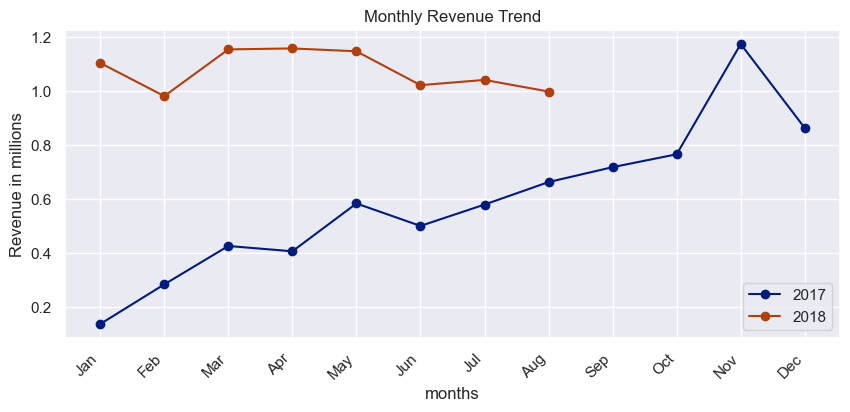

In [8]:
df = df_order.groupby(['month', 'year']).payment_value.sum().unstack().reset_index()
sort_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df.index = pd.CategoricalIndex(df['month'], categories=sort_order, ordered=True)
df = df.sort_index()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index, df.iloc[:, 1:]/1000000, marker='o')

# Set the y-axis tick format to millions
fmt = ticker.StrMethodFormatter('{x:,.1f}')
ax.yaxis.set_major_formatter(fmt)

# Add the "Revenue in millions" label to the y-axis
ax.set_ylabel('Revenue in millions')
ax.set_xlabel('months')
ax.set_title('Monthly Revenue Trend')

# Set the x-axis tick labels and rotation
ax.set_xticks(range(len(sort_order)))
ax.set_xticklabels(sort_order, rotation=45, ha='right')

ax.legend(df.iloc[:, 1:].columns)

plt.show()

**Result**: The chart above shows the revenue trend of the company. The highest revenue for the period in review was generated in Nov. 2017. Although, the monthly revenue in 2018 are better than 2017 which is impressive and commendable. The inconsistent month-on-month revenue generation in 2018 should be monitored.

#### 2. How many orders were placed on Olist, and how does this vary by month or season?

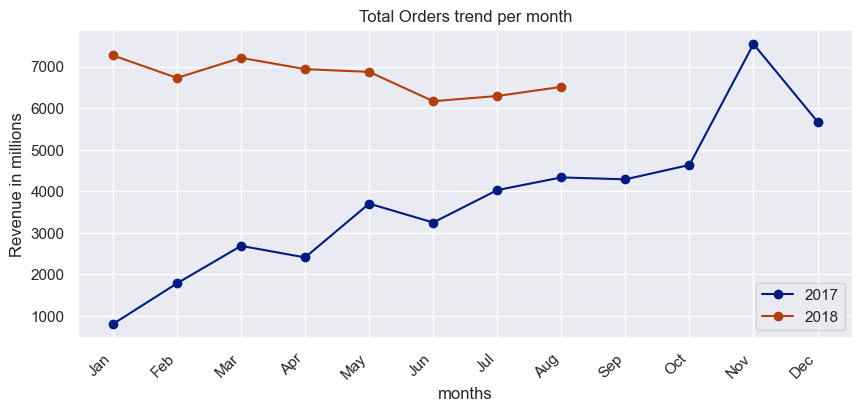

In [9]:
total_order = clean_data(orders)
df1 = total_order.groupby(['month', 'year']).order_id.count().unstack().reset_index()
sort_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df1.index = pd.CategoricalIndex(df1['month'], categories=sort_order, ordered=True)
df1 = df1.sort_index()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df1.index, df1.iloc[:, 1:], marker='o')


# Add the "Revenue in millions" label to the y-axis
ax.set_ylabel('Revenue in millions')
ax.set_xlabel('months')
ax.set_title('Total Orders trend per month')

# Set the x-axis tick labels and rotation
ax.set_xticks(range(len(sort_order)))
ax.set_xticklabels(sort_order, rotation=45, ha='right')

ax.legend(df.iloc[:, 1:].columns)

plt.show()

**Result**: The chart above shows the trend of orders per month. Nov. The company recorder that highets order (7544) in Nov. 2017. then there was a drop in Dec. 2017, this might be due to festivities and holidays. However, The sales volume trend since an impressive performance should be monitored as there has been a inconsistent performance in sales volume.

#### 3. What are the most popular product categories on Olist, and how do their sales volumes compare to each other

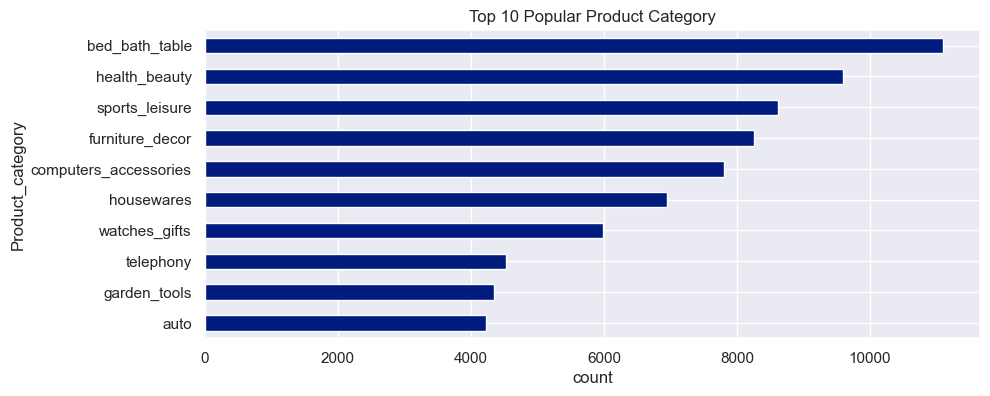

In [10]:
pop_pro = pop_final.groupby('product_category_name_english').product_category_name_english.count().\
sort_values(ascending = False)


fig, ax = plt.subplots(figsize=(10, 4))
pop_pro.head(10).sort_values(ascending = True).plot(kind = 'barh')
ax.set_ylabel('Product_category')
ax.set_xlabel('count')
ax.set_title('Top 10 Popular Product Category')
plt.show()

**Result**: The above shows that bed_bath_table, health_beauty, and sport_leisure are the top 3 most popular products of Olist and the sales trend over time is answered in question 10.

### 4. Average Order Value

In [11]:
AOV = total_revenue/len(df_order.order_id)
print(f'The Average Order Value is {AOV:.2f}')

The Average Order Value is 153.41


### 5. Active Sellers 

In [12]:
Active = dist.groupby('seller_id').agg(total = ('seller_id','count'), revenue = ('payment_value', 'sum')).\
sort_values(by = 'total', ascending = False).head(10).reset_index()
Active

,seller_id,total,revenue
0,6560211a19b47992c3666cc44a7e94c0,2039,151636.13
1,4a3ca9315b744ce9f8e9374361493884,2009,238440.31
2,1f50f920176fa81dab994f9023523100,1940,142757.03
3,cc419e0650a3c5ba77189a1882b7556a,1819,132877.06
4,da8622b14eb17ae2831f4ac5b9dab84a,1574,188062.51
5,955fee9216a65b617aa5c0531780ce60,1501,160694.86
6,1025f0e2d44d7041d6cf58b6550e0bfa,1443,174710.82
7,7c67e1448b00f6e969d365cea6b010ab,1375,241374.82
8,ea8482cd71df3c1969d7b9473ff13abc,1204,54757.67
9,7a67c85e85bb2ce8582c35f2203ad736,1175,163278.78


The table above showed the top 10 active sellers and the revenue generated by those sellers on olist 

### 6. Distribution of seller rating and sales performance

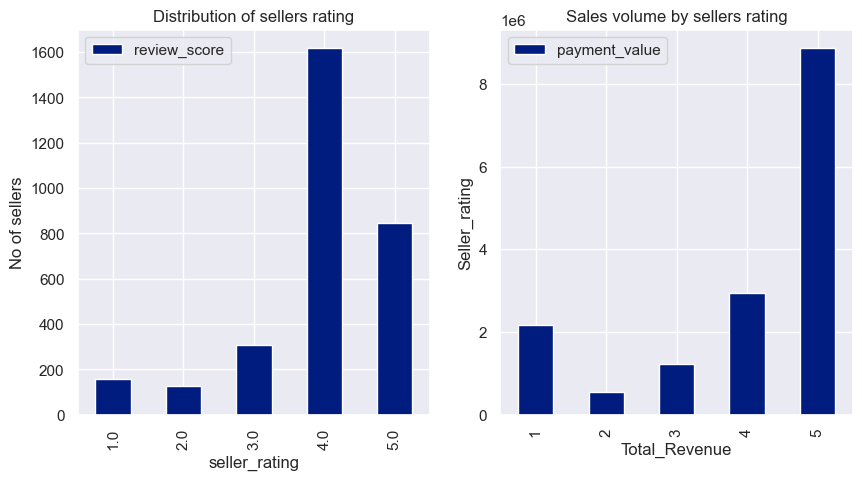

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Chart 1
seller_rating = dist_final.groupby('seller_id').review_score.mean().to_frame().reset_index().round({'review_score': 0})
seller_rating = seller_rating.review_score.value_counts().to_frame().sort_index()
seller_rating.plot(kind='bar', ax=ax1)
ax1.set_xlabel('seller_rating')
ax1.set_ylabel('No of sellers')
ax1.set_title('Distribution of sellers rating')

# Chart 2
seller_revenue = dist_final.groupby('review_score').payment_value.sum().to_frame()
seller_revenue.plot(kind='bar', ax=ax2)
ax2.set_xlabel('Total_Revenue')
ax2.set_ylabel('Seller_rating')
ax2.set_title('Sales volume by sellers rating')

plt.show()


**Result**: From the charts above, there are more top rated sellers on olist, with over 2400 sellers rated 4+. This shows the quality of service/product rendered by the sellers on olist. Additionally, it can be seen that the top rated sellers are generating more revenue. sellers with rating 4+ generated over 11M (73%) of thecompany total revenue 

#### 7. How many customers have made repeat purchases on Olist, and what percentage of total sales do they account for?

I used 10 as benchmark for repeated orders, customers that have made up to 10 and above orders are considered as repeated customers

In [14]:
rep = df_order.order_id.value_counts().to_frame()
repeat = (rep[rep.order_id >= 10])
repeat10 = df_order[df_order.order_id.isin(repeat.index)]
print(repeat10.customer_id.nunique())
repeat_value = repeat10.groupby('customer_id').agg(total = ('customer_id', 'count'), revenue = ('payment_value', 'sum')).\
sort_values(by = 'total', ascending = False).reset_index()
repeat_value

33


,customer_id,total,revenue
0,9af2372a1e49340278e7c1ef8d749f34,29,457.99
1,92cd3ec6e2d643d4ebd0e3d6238f69e2,26,62.68
2,b246eeed30b362c09d867b9e598bee51,22,40.85
3,270c23a11d024a44c896d1894b261a83,21,161.32
4,13aa59158da63ba0e93ec6ac2c07aacb,19,205.74
5,eed931d3a5222a9a511d18be7fd2a5ba,19,82.73
6,1eebfdb7083031b40f727fb71f6cd5b2,15,86.99
7,de832e8dbb1f588a47013e53feaa67cc,15,740.76
8,d1ea705f2fdd8f98eff86c2691652e60,14,529.55
9,7bb57d182bdc11653fac1593436df8bf,14,100.57


**Result**: The table above shows customers that has made up to 10 and above orders. However, the revenue generated by those cutomers seems quite small. This shows that there are customers that has made less than 10 order and contributed more to the company.

#### 8: What is the average customer rating for products sold on Olist, and how does this impact sales performance? 

In [15]:
cust_rev = order_rev.merge(pop_f, on = 'order_id', how = 'left')
cust_pro_rev = clean_dist(cust_rev)  #using defined function to clean merged dataset

cust_pro_rev.dropna(subset = ['order_item_id', 'review_id', 'order_id','product_id','seller_id','shipping_limit_date', 'price',\
                      'freight_value', 'payment_value'], axis = 0, inplace = True)

cust_review = cust_pro_rev.groupby('product_category_name_english').agg({'review_score':'mean', 'payment_value':'sum'}).\
round({'review_score': 0})
cust_review.groupby('review_score').payment_value.sum().to_frame()

,payment_value
review_score,
2.0,324.51
3.0,344521.78
4.0,15197414.73
5.0,954.99


**Result**: The above table shows how sales are distributed across various customer rating. As shown, majority of the customers rate the products sold quite high as the average minimum rating is 2.0, and top rating products >= 4.0 are generating the highest sales. 

#### 9. What is the average order cancellation rate on Olist, and how does this impact seller performance?.

In [16]:
df_can = df_c[(df_c.order_status == 'unavailable')|(df_c.order_status == 'canceled')]
canceled = len(df_can)
canc_val = df_can.payment_value.sum().round(2)
print(f'There is a total of {canceled} canceled transactions')
print(f'Value of canceled transactions: {canc_val}')

There is a total of 1261 canceled transactions
Value of canceled transactions: 257323.4


**Result**: There are 1261 total canceled transactions in the dataset, which is just about 1.2% of the company's total orders, this seems quite low and might not really impact the company's revenue. Moreso, the cancelled transactions would have added only 257323.4 (1.7%) to the company's revenue.

#### 10. What are the top-selling products on Olist, and how have their sales trends changed over time?

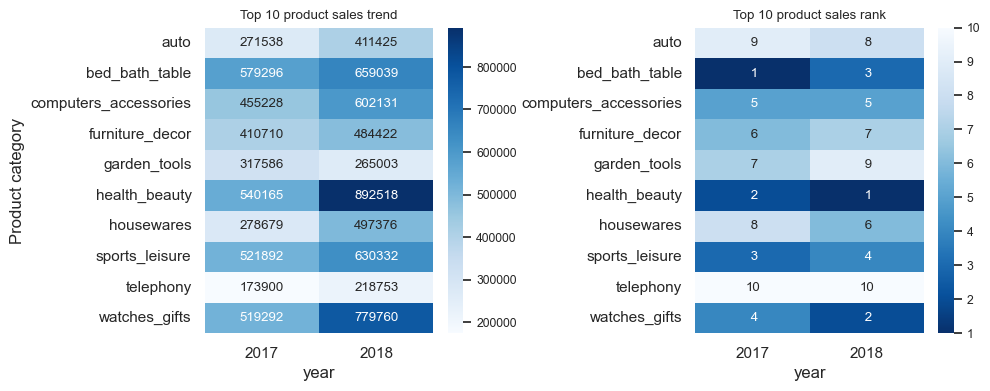

In [17]:
p10 = pop_pro.head(10)
p10i = pop_final[pop_final.product_category_name_english.isin(p10.index)]
top_product = p10i.groupby(['product_category_name_english', 'year']).payment_value.sum().unstack()\
.reset_index().set_index('product_category_name_english')
top_product_rank = top_product.rank(ascending = False, method = "average")

# Create subplots and plot each chart on a separate axis
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

sns.set(palette="dark", font_scale=0.8)
sns.heatmap(top_product, annot=True, fmt="2.0f", cmap="Blues", ax=ax1)
ax1.set_title("Top 10 product sales trend")
ax1.set_ylabel("Product category")

sns.heatmap(top_product_rank, annot=True, fmt="2.0f", cmap="Blues_r", ax=ax2)
ax2.set_title("Top 10 product sales rank")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

**Result**: As shown from the chart above: bed_bath_table, health_beauty, sport_leisure and watches_gifts are the top products of the company and they switch the top 4 position between themselves for both years in review. However, bed_bath_auto is the top selling/reveneu generating product in 2017 while health_beauty is leading the year 2018. Although, the 2018 dataset is not complete.

#### 11. Which payment methods are most commonly used by Olist customers, and how does this vary by product category or geographic region?

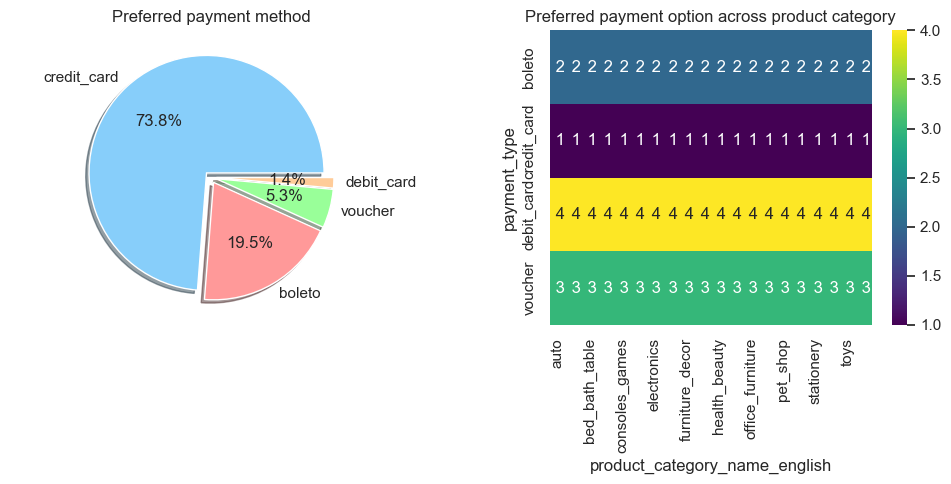

In [22]:
# Chart 1
payment = pop_final.merge(df_order, on = 'order_id', how = 'left', validate = 'many_to_many')
payment_pop = payment.payment_type.value_counts().to_frame()
payment_pop = payment.payment_type.value_counts().to_frame()
labels = payment_pop.index.tolist()
sizes = payment_pop['payment_type'].tolist()
colors = ['#87CEFA','#ff9999','#99ff99','#ffcc99']
explode = (0.05, 0.05, 0.05, 0.05)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors, explode = explode, shadow = True)
ax1.axis('equal')
ax1.set_title('Preferred payment method')

# Chart 2
p20 = pop_pro.head(20)
pay_dist = payment[payment.product_category_name_english.isin(p20.index)]
pay_20_dist = pay_dist.groupby(['payment_type', 'product_category_name_english']).payment_type.count().unstack()
pay_20_rank = pay_20_dist.rank(ascending = False, method = "average")

sns.set(palette = "dark")
sns.heatmap(pay_20_rank, annot = True, fmt = "2.0f", cmap = "viridis", ax=ax2)
ax2.set_title("Preferred payment option across product category")

plt.tight_layout()
plt.show()


**Result**: The chart above shows that credit_card is the most prefered payment method with 73.8% of the company's payment made with credit_card. Debit_card remains the least favourable method. Also the second chart confirms also that credit card is the most preferred option across different product category

### 12. How do customer reviews and ratings affect sales and product performance on Olist?

### This has been answered in question 6

### 13. Which product categories have the highest profit margins on Olist, and how can the company increase profitability across different categories?

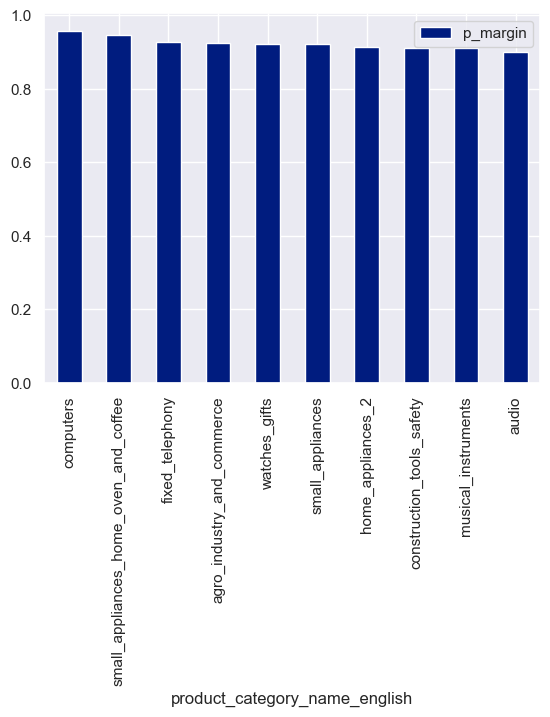

In [19]:
margin = pop_final.groupby('product_category_name_english').agg({'price':'sum', 'payment_value':'sum'}).round(2).reset_index()
margin['p_margin'] = margin.price/margin.payment_value
m20 = margin.sort_values(by = 'p_margin', ascending = False).head(10)
m20.plot(kind = 'bar', x = 'product_category_name_english', y = 'p_margin')
plt.show()

**Result**: The above is not a clear representation of the profit margin of the product, since the profit made on the products are not provided. Also, I used the price (not payment_value) of the product which is not an indication of the profit margin

#### 14. How does Olist's marketing spend and channel mix impact sales and customer acquisition costs, and how can the company optimize its marketing strategy to increase ROI?

No marketing information given in the dataset

#### 15 Geolocation having high customer density. Calculate customer retention rate according to geolocations.

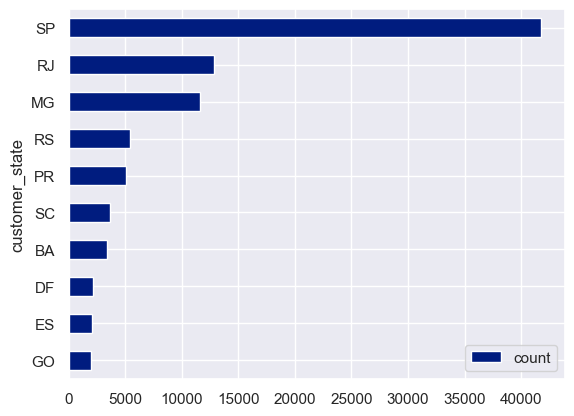

In [20]:
cust_dis = cust.groupby('customer_state').customer_state.count().to_frame()
cust_dis.rename(columns = {'customer_state':'count'}, inplace = True)
cust_dis10 = cust_dis.reset_index().sort_values(by = 'count', ascending = False).head(10)
cust_dis10.sort_values(by = 'count', ascending = True).plot(kind = 'barh', x = 'customer_state', y = 'count')
plt.show()

**Result**: From the above chart, it can be seen that the state SP has the highest customer density with over 40,000 of the company coming from that state. Followed by RJ and MG